# EasyEdit Example with **IKE**
>Tutorial author: Yachen Chang（<yachenchang@zju.edu.cn>） and Jiangtao Guan (<jiangtaoguan@zju.edu.cn>)

In this tutorial, we use `IKE` to edit `InternLM-7b` model. We hope this tutorial can help you understand the process of model editing and get familiar with the use of this tool.



# Model Editing
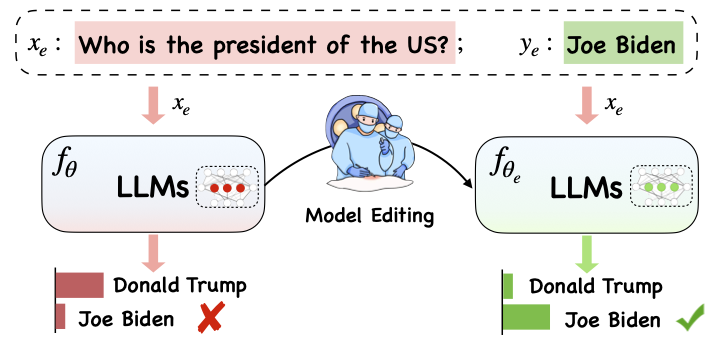

Deployed models may still make unpredictable errors. For example, Large Language Models (LLMs) notoriously *hallucinate*, *perpetuate bias*, and *factually decay*, so we should be able to adjust specific behaviors of pre-trained models.

**Model editing** aims to adjust an initial base model's $(f_\theta)$ behavior on the particular edit descriptor $[x_e, y_e]$, such as:
- $x_e$: "Who is the president of the US?
- $y_e$: "Joe Biden."

efficiently without influencing the model behavior on unrelated samples. The ultimate goal is to create an edited model$(f_\theta’)$.

# Editing Scope
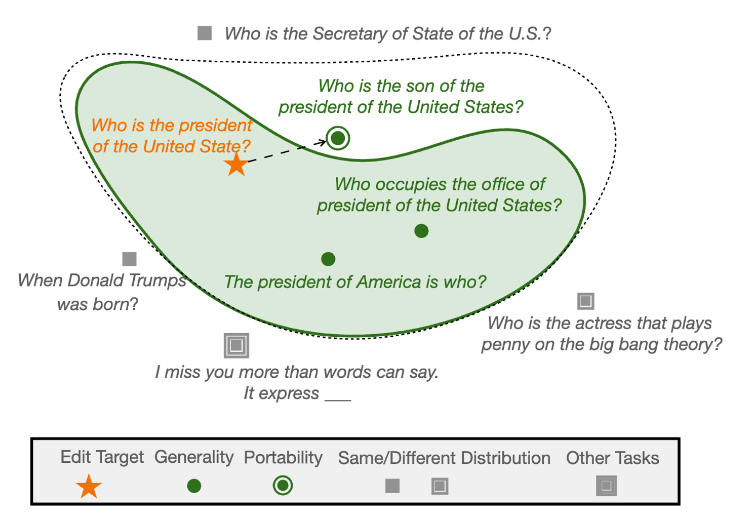

The model editing process generally impacts the predictions for a broad set of inputs **that are closely** associated with the edit example, called the **editing scope**.


A successful edit should adjust the model’s behavior within the editing scope while remaining unrelated inputs(as below formula).


$f_{\theta_{e}}(x) = \begin{cases}
y_e & \text{if } x \in I(x_e,y_e) \\
f_{\theta}(x) & \text{if } x \in O(x_e, y_e) \end{cases}$

In addition to this, the performance of model editing should be measured from multiple dimensions:

- `Reliability`: the success rate of editing with a given editing description
- `Generalization`: the success rate of editing **within** the editing scope
- `Locality`: whether the model's output changes after editing for unrelated inputs
- `Portability`: the success rate of editing for factual reasoning(one hop, synonym, one-to-one relation)
- `Efficiency`: time and memory consumption required during the editing process


# Method: **IKE**

Paper: [Can We Edit Factual Knowledge by In-Context Learning?](https://arxiv.org/abs/2305.12740)

**IKE** (In-context Knowledge Editing), is a way of editing factual knowledge in large language models **without modifying their parameters**, but by **providing different types of natural language demonstrations** as part of the input.  
It can achieve competitive knowledge editing performance **with less computation overhead and side effects**, as well as better scalability and interpretability.

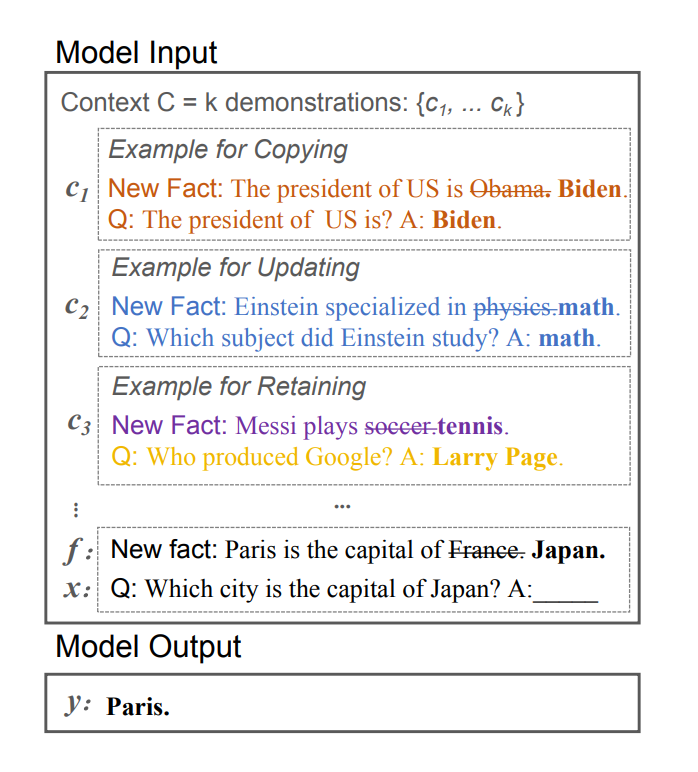

# Model: **InternLM-7b**

[InternLM: A Multilingual Language Model with Progressively Enhanced Capabilities](https://github.com/InternLM/InternLM)

Paper URL: https://github.com/InternLM/InternLM-techreport/blob/main/InternLM.pdf

Project URL: https://internlm.org/

Code URL: https://github.com/InternLM/InternLM-techreport


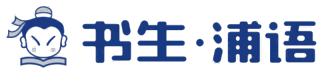

## Prepare the runtime environment

In [1]:
## Clone Repo
!git clone https://github.com/zjunlp/EasyEdit
%cd EasyEdit
!ls

/root/autodl-tmp/EasyEdit
Dockerfile  easyeditor	hparams		    requirements.txt	tutorial.pdf
LICENSE     edit.py	hugging_cache	    results
README.md   examples	logs		    test.py
data.zip    figs	multimodal_edit.py  tutorial-notebooks


In [2]:
!pip install -r requirements.txt

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [3]:
!pip install fairscale

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [4]:
!pip list

Package                        Version
------------------------------ -------------------
absl-py                        1.4.0
accelerate                     0.24.1
aiofiles                       22.1.0
aiohttp                        3.8.6
aiosignal                      1.3.1
aiosqlite                      0.18.0
antlr4-python3-runtime         4.8
anyio                          3.6.2
argon2-cffi                    21.3.0
argon2-cffi-bindings           21.2.0
arrow                          1.2.3
asttokens                      2.2.1
async-timeout                  4.0.3
attrs                          22.2.0
Babel                          2.12.1
backcall                       0.2.0
beautifulsoup4                 4.11.2
bleach                         6.0.0
blessed                        1.20.0
brotlipy                       0.7.0
cachetools                     5.3.0
certifi                        2021.5.30
cffi                           1.14.6
chardet                        4.0.0
charset-no

## Config Method Parameters
> ./hparams/IKE/internlm-7b.yaml.

You may need to modify 'model_name' to the directory where the model is saved.

```python
# For IKE hparams:
alg_name: "IKE"
model_name: "./hugging_cache/internlm-7b"
sentence_model_name: "./hugging_cache/all-MiniLM-L6-v2"
device: 0
results_dir: "./results"

k: 16
model_parallel: false
```



## Import modules & Run

### Download models

To load weights, you need to first download the model weights and save them in the same directory specified by the 'model_name' in the configuration file.

In [ ]:
from huggingface_hub import snapshot_download

snapshot_download("sentence-transformers/all-MiniLM-L6-v2",resume_download=True,local_dir='./hugging_cache/all-MiniLM-L6-v2',ignore_patterns=['*.ot','*.h5'])
snapshot_download("internlm/internlm-7b",resume_download=True,local_dir='./hugging_cache/internlm-7b')

### For InternLM-7b Model

In [2]:
from easyeditor import BaseEditor
from easyeditor import IKEHyperParams
from easyeditor.models.ike.util import encode_ike_facts
from sentence_transformers import SentenceTransformer


prompts = ['Q: The president of the US is? A:',]
ground_truth = ['Donald Trump']
target_new = ['Joe Biden']
subject = ['president']
rephrase_prompts = ['The leader of the United State is']

# IKE need train_ds(For getting In-Context prompt)
train_ds = [
    {
        'prompt': 'Q: The president of the US is? A:',
        'target_new': 'Joe Biden',
        'rephrase_prompt': 'The leader of the United State is',
        'locality_prompt': 'The president of Russia is ',
        'locality_ground_truth': 'Putin'
    },
    {
        'prompt': 'Einstein specialized in',
        'target_new': 'math',
        'rephrase_prompt': 'Einstein is good at',
        'locality_prompt': 'Q: Which subject did Newton specialize in? A: ',
        'locality_ground_truth': 'physics'
    },
    # add more if needed
]

hparams = IKEHyperParams.from_hparams('./hparams/IKE/internlm-7b')
editor = BaseEditor.from_hparams(hparams)
# Initialize SentenceTransformer model
sentence_model = SentenceTransformer(hparams.sentence_model_name)
# Generate and save sentence embeddings
encode_ike_facts(sentence_model, train_ds, hparams)

metrics, edited_model, _ = editor.edit(
    prompts=prompts,
    ground_truth=ground_truth,
    rephrase_prompts=rephrase_prompts, # new para
    target_new=target_new,
    subject=subject,
    train_ds=train_ds,
    copy=True,
    return_orig_weights=True,
    keep_original_weight=True,
)

print(metrics)



2023-11-10 10:35:27,475 - easyeditor.editors.editor - INFO - Instantiating model
11/10/2023 10:35:27 - INFO - easyeditor.editors.editor -   Instantiating model


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Some weights of the model checkpoint at ./hugging_cache/internlm-7b were not used when initializing InternLMForCausalLM: ['model.layers.29.self_attn.rotary_emb.inv_freq', 'model.layers.1.self_attn.rotary_emb.inv_freq', 'model.layers.11.self_attn.rotary_emb.inv_freq', 'model.layers.24.self_attn.rotary_emb.inv_freq', 'model.layers.23.self_attn.rotary_emb.inv_freq', 'model.layers.25.self_attn.rotary_emb.inv_freq', 'model.layers.22.self_attn.rotary_emb.inv_freq', 'model.layers.10.self_attn.rotary_emb.inv_freq', 'model.layers.2.self_attn.rotary_emb.inv_freq', 'model.layers.31.self_attn.rotary_emb.inv_freq', 'model.layers.15.self_attn.rotary_emb.inv_freq', 'model.layers.16.self_attn.rotary_emb.inv_freq', 'model.layers.8.self_attn.rotary_emb.inv_freq', 'model.layers.14.self_attn.rotary_emb.inv_freq', 'model.layers.5.self_attn.rotary_emb.inv_freq', 'model.layers.6.self_attn.rotary_emb.inv_freq', 'model.layers.30.self_attn.rotary_emb.inv_freq', 'model.layers.0.self_attn.rotary_emb.inv_freq', 'm

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

11/10/2023 10:36:47 - INFO - sentence_transformers.SentenceTransformer -   Load pretrained SentenceTransformer: ./hugging_cache/all-MiniLM-L6-v2
11/10/2023 10:36:48 - INFO - sentence_transformers.SentenceTransformer -   Use pytorch device: cuda
2023-11-10 10:36:48,109 - easyeditor.editors.editor - INFO - Execution 0 editing took 0.27939701080322266
11/10/2023 10:36:48 - INFO - easyeditor.editors.editor -   Execution 0 editing took 0.27939701080322266
2023-11-10 10:36:48,622 - easyeditor.editors.editor - INFO - Evaluation took 0.5113382339477539
11/10/2023 10:36:48 - INFO - easyeditor.editors.editor -   Evaluation took 0.5113382339477539
2023-11-10 10:36:48,625 - easyeditor.editors.editor - INFO - 0 editing: Q: The president of the US is? A: -> Joe Biden  
 {'pre': {'rewrite_acc': 0.3333333432674408, 'portability': {}, 'rephrase_acc': 0.6666666865348816}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Q: The president of the US is? A:', 'target_new': 'Joe Biden', 'ground_truth': 'Donald

[{'pre': {'rewrite_acc': 0.3333333432674408, 'portability': {}, 'rephrase_acc': 0.6666666865348816}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Q: The president of the US is? A:', 'target_new': 'Joe Biden', 'ground_truth': 'Donald Trump', 'portability': {}, 'locality': {}, 'subject': 'president', 'rephrase_prompt': 'The leader of the United State is'}, 'time': 0.27939701080322266, 'post': {'rewrite_acc': 0.6666666865348816, 'locality': {}, 'portability': {}, 'rephrase_acc': 0.6666666865348816}}]


### Reliability Test

In [3]:
from transformers import AutoTokenizer, AutoModelForCausalLM
tokenizer = AutoTokenizer.from_pretrained('./hugging_cache/internlm-7b',trust_remote_code=True)
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side='left'

model = AutoModelForCausalLM.from_pretrained('./hugging_cache/internlm-7b',trust_remote_code=True).to('cuda')

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Some weights of the model checkpoint at ./hugging_cache/internlm-7b were not used when initializing InternLMForCausalLM: ['model.layers.29.self_attn.rotary_emb.inv_freq', 'model.layers.1.self_attn.rotary_emb.inv_freq', 'model.layers.11.self_attn.rotary_emb.inv_freq', 'model.layers.24.self_attn.rotary_emb.inv_freq', 'model.layers.23.self_attn.rotary_emb.inv_freq', 'model.layers.25.self_attn.rotary_emb.inv_freq', 'model.layers.22.self_attn.rotary_emb.inv_freq', 'model.layers.10.self_attn.rotary_emb.inv_freq', 'model.layers.2.self_attn.rotary_emb.inv_freq', 'model.layers.31.self_attn.rotary_emb.inv_freq', 'model.layers.15.self_attn.rotary_emb.inv_freq', 'model.layers.16.self_attn.rotary_emb.inv_freq', 'model.layers.8.self_attn.rotary_emb.inv_freq', 'model.layers.14.self_attn.rotary_emb.inv_freq', 'model.layers.5.self_attn.rotary_emb.inv_freq', 'model.layers.6.self_attn.rotary_emb.inv_freq', 'model.layers.30.self_attn.rotary_emb.inv_freq', 'model.layers.0.self_attn.rotary_emb.inv_freq', 'm

In [13]:
ike_generation_prompts = [
    "Lionel Messi plays basketball. \
    Q: What sport does Lionel Messi play? A: Basketball. \
    Lionel Messi is a basketball player. \
    Q: What sport does Lionel Messi play? A:",
    "The president of the US is Biden. \
    Q: Who is the president of the US? A: Biden. \
    Biden is the leader of the United State. \
    Q: Who is the president of the US? A:",
]
generation_prompts = [
    "Q: What sport does Lionel Messi play? A:",
    "Q: Who is the president of the US? A:",
]

max_length=50
batch = tokenizer(generation_prompts, return_tensors='pt', padding=True)
edited_batch = tokenizer(ike_generation_prompts, return_tensors='pt', padding=True)


pre_edit_outputs = model.generate(
    input_ids=batch['input_ids'].to('cuda'),
    attention_mask=batch['attention_mask'].to('cuda'),
    max_length=max_length
)

post_edit_outputs = edited_model.generate(
    input_ids=edited_batch['input_ids'].to('cuda'),
    attention_mask=edited_batch['attention_mask'].to('cuda'),
    max_length=max_length
)




print('*'*100)
print('Pre-Edit Outputs: ', [tokenizer.decode(x) for x in pre_edit_outputs.detach().cpu().numpy().tolist()])
print('Post-Edit Outputs: ', [tokenizer.decode(x) for x in post_edit_outputs.detach().cpu().numpy().tolist()])


Input length of input_ids is 50, but `max_length` is set to 50. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


****************************************************************************************************
Pre-Edit Outputs:  [' <s>Q: What sport does Lionel Messi play? A: Football\n\nA: Lionel Messi is a professional footballer who plays for Spanish club Barcelona and the Argentina national team. He is widely regarded as one of the greatest players of', ' </s><s>Q: Who is the president of the US? A: Donald Trump\n\nA: Donald Trump\n\nQ: Who is the president of the US? A: Donald Trump\n\nA: Donald Trump\n\nQ: Who is the president of the']
Post-Edit Outputs:  [' <s>Lionel Messi plays basketball.     Q: What sport does Lionel Messi play? A: Basketball.     Lionel Messi is a basketball player.     Q: What sport does Lionel Messi play? A: Basketball', ' </s></s><s>The president of the US is Biden.     Q: Who is the president of the US? A: Biden.     Biden is the leader of the United State.     Q: Who is the president of the US? A: Biden']


### Generalization test

In [14]:
ike_generation_prompts = [
    "Lionel Messi plays basketball. \
    Q: What is Messi's profession? A: Basketball. \
    Lionel Messi is a basketball player. \
    Q: What sports is Messi good at? A:",
    "The president of the US is Biden. \
    Q: Who is the president of the US? A: Biden. \
    Biden is the leader of the United State. \
    Q: The leader of the United State is? A:",
]
generation_prompts = [
    "Q: What sports is Messi good at? A:",
    "Q: The leader of the United State is? A:",
]

max_length=50
batch = tokenizer(generation_prompts, return_tensors='pt', padding=True)
edited_batch = tokenizer(ike_generation_prompts, return_tensors='pt', padding=True)


pre_edit_outputs = model.generate(
    input_ids=batch['input_ids'].to('cuda'),
    attention_mask=batch['attention_mask'].to('cuda'),
    max_length=max_length
)

post_edit_outputs = edited_model.generate(
    input_ids=edited_batch['input_ids'].to('cuda'),
    attention_mask=edited_batch['attention_mask'].to('cuda'),
    max_length=max_length
)




print('*'*100)
print('Pre-Edit Outputs: ', [tokenizer.decode(x) for x in pre_edit_outputs.detach().cpu().numpy().tolist()])
print('Post-Edit Outputs: ', [tokenizer.decode(x) for x in post_edit_outputs.detach().cpu().numpy().tolist()])


****************************************************************************************************
Pre-Edit Outputs:  [' <s>Q: What sports is Messi good at? A: Messi is a very versatile player, who can play in any position on the pitch. He is a natural goal scorer, but he can also play as a striker, a w', ' <s>Q: The leader of the United State is? A: Donald Trump\nQ: The leader of the United State is? A: Donald Trump\nQ: The leader of the United State is? A: Donald Trump\nQ: The leader']
Post-Edit Outputs:  [" </s><s>Lionel Messi plays basketball.     Q: What is Messi's profession? A: Basketball.     Lionel Messi is a basketball player.     Q: What sports is Messi good at? A: Basketball.", ' <s>The president of the US is Biden.     Q: Who is the president of the US? A: Biden.     Biden is the leader of the United State.     Q: The leader of the United State is? A: Biden.']


### Locality test

In [15]:
ike_generation_prompts = [
    "Lionel Messi plays basketball. \
    Q: What is Messi's profession? A: Basketball. \
    Lionel Messi is a basketball player. \
    Q: What sport does Cristiano Ronaldo play? A:",
    "The president of the US is Biden. \
    Q: Who is the president of the US? A: Biden. \
    Biden is the leader of the United State. \
    Q: Who is the president of the Russia? A:",
]
generation_prompts = [
    "Q: What sport does Cristiano Ronaldo play? A:",
    "Q: Who is the president of the Russia? A:",
]

max_length=50
batch = tokenizer(generation_prompts, return_tensors='pt', padding=True)
edited_batch = tokenizer(ike_generation_prompts, return_tensors='pt', padding=True)


pre_edit_outputs = model.generate(
    input_ids=batch['input_ids'].to('cuda'),
    attention_mask=batch['attention_mask'].to('cuda'),
    max_length=max_length
)

post_edit_outputs = edited_model.generate(
    input_ids=edited_batch['input_ids'].to('cuda'),
    attention_mask=edited_batch['attention_mask'].to('cuda'),
    max_length=max_length
)




print('*'*100)
print('Pre-Edit Outputs: ', [tokenizer.decode(x) for x in pre_edit_outputs.detach().cpu().numpy().tolist()])
print('Post-Edit Outputs: ', [tokenizer.decode(x) for x in post_edit_outputs.detach().cpu().numpy().tolist()])


****************************************************************************************************
Pre-Edit Outputs:  [' <s>Q: What sport does Cristiano Ronaldo play? A: Soccer\n\nA: Cristiano Ronaldo is a professional soccer player who plays for Juventus and the Portugal national team. He is widely considered to be one of the greatest players', ' </s><s>Q: Who is the president of the Russia? A: Vladimir Putin\n\nA: Vladimir Putin\n\nQ: Who is the president of the Russia? A: Vladimir Putin\n\nA: Vladimir Putin\n\nQ: Who is the president of the']
Post-Edit Outputs:  [" <s>Lionel Messi plays basketball.     Q: What is Messi's profession? A: Basketball.     Lionel Messi is a basketball player.     Q: What sport does Cristiano Ronaldo play? A: Soccer.", ' <s>The president of the US is Biden.     Q: Who is the president of the US? A: Biden.     Biden is the leader of the United State.     Q: Who is the president of the Russia? A: Putin.']
